# RAVE - General Model

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pickle as pkl
import pickle5 as pkl5
from copy import deepcopy
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
from scipy import io
import numpy as np
from sklearn.decomposition import PCA
import json

from rave.model.architectures import Autoencoder, CustomDataParallel
from rave.model.utils import ModelOutputs
from rave.model.training import train_model
from rave.evaluation.utils import print_result_dictionary, get_sim_ground_truth_labels
from rave.evaluation.score import get_all_scores
from rave.evaluation.embed import get_embedding
from rave.evaluation.visualize import visualize_embedding_basic
from rave.data.datasets import get_bc_data

# Define paths

In [18]:
your_path_to_model_directory = ...
your_path_to_params_file = os.path.join(your_path_to_model_directory, 'params.pkl')


In [11]:
your_data_directory = ...
your_dataset_file_name_A = ...
your_dataset_file_name_B = ...

In [12]:
ipl_file1=.../ipl.mat'
ipl_file2=.../BC_Profiles_Helmstaedter.txt'

### load IPL info files

In [13]:
with open(ipl_file1, 'rb') as f:
    ipl_dict = io.loadmat(f)
with open(ipl_file2, 'rb') as f:
    ipl_depth_per_type_em = np.loadtxt(f)

# load dataset

In [14]:
type_names = ["1", "2", "3a", "3b", "4", "5t", "5o", "5i", "X", "6", "7", "8", "9", "R"]

In [15]:
dataset = get_bc_data(your_data_directory, franke_file_name=your_dataset_file_name_A, szatko_file_name=your_dataset_file_name_B,verbose=True)

Splitting by Type Labels, all type labels must be in first scan
5-Fold Cross-Validation Train=9364 / Val=2342
baseline adversarial accuracy (biggest class 0.0) 0.6471040492055357
baseline cell type accuracy (biggest class 3.0) 0.12462046204620462


In [16]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train, y_type_val] = \
dataset.get_split_numpy(0)

# load model and training parameters

In [19]:
with open(your_path_to_params_file, "rb") as f:
    params = pkl5.load(f)

# Update params to be compatible with training v1

In [21]:
config = deepcopy(params)

In [22]:
config_update = {
    "datatype":"bio",
    "data_dir" : your_data_directory,
    "dataset_A_fname" : your_dataset_file_name_A,
    "dataset_B_fname" : your_dataset_file_name_B,
    "model_type": "general",
    "model_architecture": "autoencoder"}

In [23]:
config.update(config_update)

In [24]:
config["training"]["batch_size"] = 20160
config["training"]["reconstruction_loss"] = "torch.nn.functional.mse_loss"
config["training"]["type_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["domain_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["batched_training"] = False
config["training"]["optim_step_count"] = 1

# Load model and ... 

In [25]:
model = Autoencoder(dataset.D, **config["model"])

### ... instantiate with state dict from checkpoint

In [26]:
with open(os.path.join(your_path_to_model_directory, "model.pth"), "rb") as f:
    state_dict = torch.load(f)
model.load_state_dict(state_dict)

<All keys matched successfully>

### ... or train again

In [27]:
#model = train_model(config)

In [28]:
model_output = ModelOutputs()
model_output.get_model_outputs(model, dataset)

In [29]:
num_hidden = params["model"]["num_hidden"]
print(num_hidden)

49


# run evaluation on PCA-transformed, raw data

## get PCA transform of raw data

In [32]:
pca_obj = PCA(n_components=num_hidden, whiten=True)
pca_train = pca_obj.fit_transform(x_train)

In [33]:
result_dict_raw, output_pre = get_all_scores(dataset, pca_train, pca_obj.transform(x_val),
                            pca_obj.transform(dataset.X_test), y_scan_train, y_scan_val,
                            dataset.Y_scan_test,
                       y_type_train, y_type_val, dataset.Y_type_test, 
                        dataset.ipl_depth_test,
                                             n_jobs=1,
                        conf_weighted_kde_estimate=True, correct_label_mixup=False,
                                            ipl_file1=ipl_file1,
                                            ipl_file2=ipl_file2)

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 2021}
val set accuracy: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 0}
scan train score seed 0: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 42}
scan train score seed 1: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 1067}
scan train score seed 2: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 99}
scan train score seed 3: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.7, 'n_estimators': 20, 'random_state': 50}
scan train score seed 4: 1.000
{'ccp_alp

In [34]:
print_result_dictionary(result_dict_raw, dataset)

Mean +- sd domain accuracy: 1.00 +- 0.001
Mean +- sd type accuracy for dataset 0: 0.84 +- 0.007
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.564 +- 0.03; 0.519
2:  0.415 +- 0.06; 0.336
3a:  0.505 +- 0.05; 0.369
3b:  0.462 +- 0.02; 0.431
4:  0.579 +- 0.03; 0.531
5t:  0.617 +- 0.02; 0.566
5o:  0.574 +- 0.05; 0.469
5i:  0.612 +- 0.03; 0.573
X:  0.647 +- 0.03; 0.624
6:  0.554 +- 0.00; 0.554
7:  0.572 +- 0.08; 0.445
8:  0.409 +- 0.09; 0.283
9:  0.587 +- 0.01; 0.560
R:  0.620 +- 0.01; 0.617
domain accuracy: 1.00 +- 0.001
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): 0.121 +- 0.03


# evaluate model: domain classification, type classification

In [35]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train,
         y_type_val] = dataset.get_split(0, "cpu")

In [36]:
result_dict_rave, output = get_all_scores(dataset, model_output.z_train,
              model_output.z_val,
              model_output.z_test,
              y_scan_train, y_scan_val, 
              dataset.Y_scan_test,
              y_type_train, y_type_val,
              dataset.Y_type_test,
               dataset.ipl_depth_test,
                n_jobs=1,
                ppath = None, 
                conf_weighted_kde_estimate=True,
                correct_label_mixup=False,
                 ipl_file1=ipl_file1,
                 ipl_file2=ipl_file2
              )

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 2021}
val set accuracy: 0.785
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 0}
scan train score seed 0: 0.980
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 42}
scan train score seed 1: 0.982
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 1067}
scan train score seed 2: 0.981
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 99}
scan train score seed 3: 0.983
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 50}
scan train score seed 4: 0.981
{'ccp_alp

In [37]:
print_result_dictionary(result_dict_rave, dataset)

Mean +- sd domain accuracy: 0.77 +- 0.005
Mean +- sd type accuracy for dataset 0: 0.68 +- 0.008
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.412 +- 0.01; 0.384
2:  0.296 +- 0.01; 0.269
3a:  0.422 +- 0.01; 0.398
3b:  0.415 +- 0.01; 0.405
4:  0.583 +- 0.02; 0.556
5t:  0.587 +- 0.01; 0.567
5o:  0.620 +- 0.02; 0.599
5i:  0.526 +- 0.01; 0.517
X:  0.695 +- 0.01; 0.682
6:  0.518 +- 0.05; 0.439
7:  0.560 +- 0.01; 0.538
8:  0.395 +- 0.03; 0.365
9:  0.407 +- 0.02; 0.377
R:  0.560 +- 0.04; 0.496
domain accuracy: 0.77 +- 0.005
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): 0.800 +- 0.02


# Get cell type labels for Raw and RAVE

In [38]:
y_type_test_raw = np.asarray([
    np.argmax(np.bincount(temp.astype(int), minlength=14)) for temp in result_dict_raw["y_type_test_post"]])

In [39]:
y_type_test_rave = np.asarray([
    np.argmax(np.bincount(temp.astype(int), minlength=14)) for temp in result_dict_rave["y_type_test_post"]])

# Visualize ...

## ... raw traces

In [41]:
sc_map = ScalarMappable(norm=Normalize(vmin=0, vmax=13), cmap="tab20b")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/gpfs01/euler/User/dgonschorek/.local/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/gpfs01/euler/User/dgonschorek/.local/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


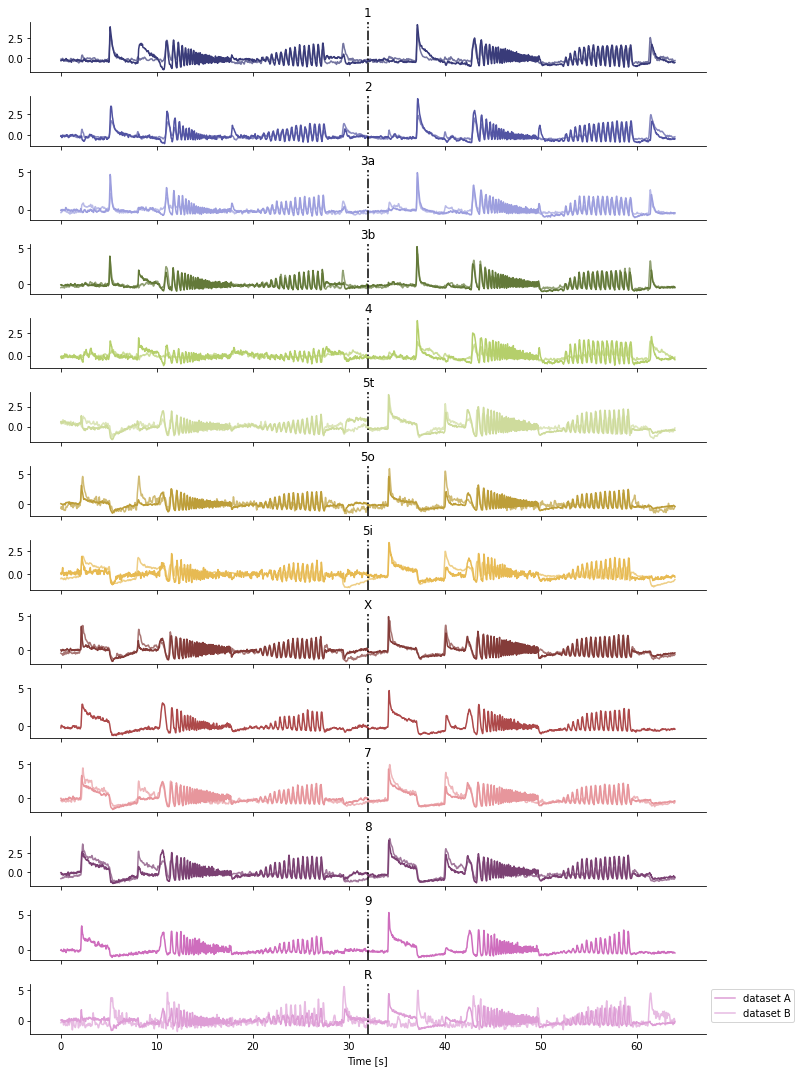

In [54]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_raw[dataset.Y_scan_test==0]==t
    axes[t].plot(time_line,
        dataset.X_test[dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=1.0, label="dataset A"
        
    )
    
    type_bool_mask = y_type_test_raw[dataset.Y_scan_test==1]==t
    axes[t].plot(time_line,
        dataset.X_test[dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.7, label="dataset B"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


## ... RAVE traces

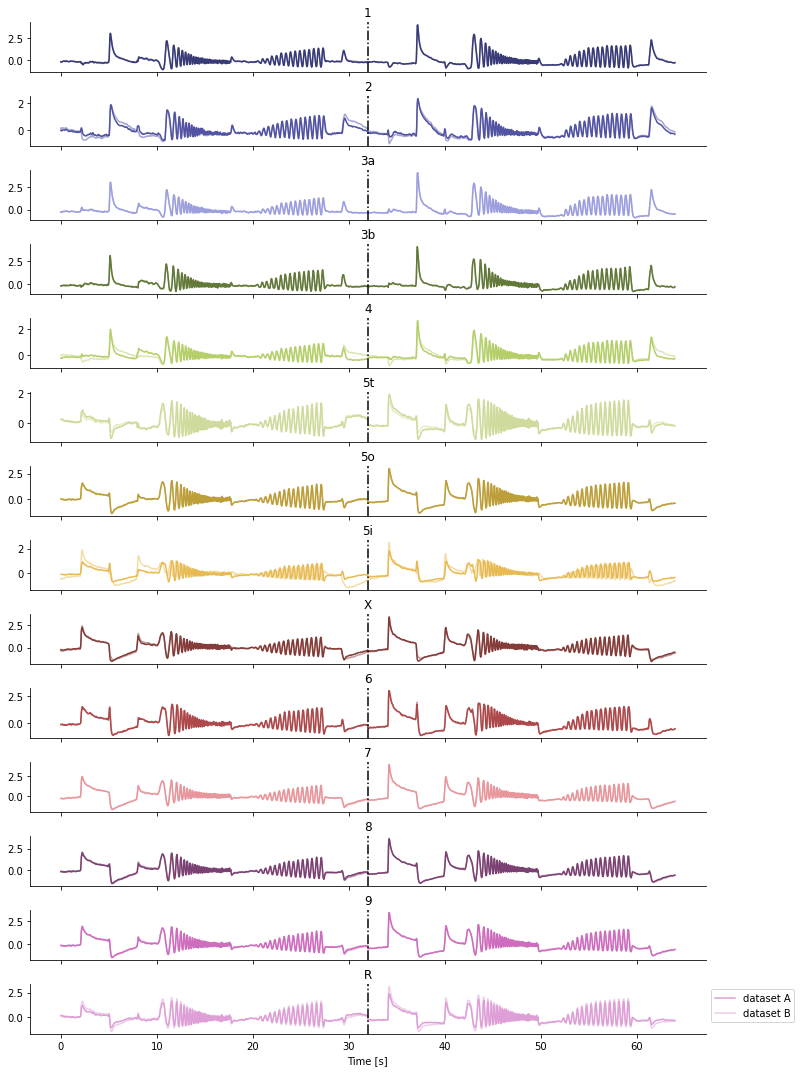

In [48]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_rave[dataset.Y_scan_test==0]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=1, label="dataset A"
        
    )
    
    type_bool_mask = y_type_test_rave[dataset.Y_scan_test==1]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.5, label="dataset B"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


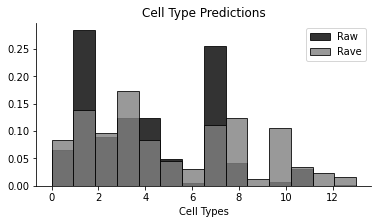

In [82]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(y_type_test_raw[dataset.Y_scan_test==1],bins=14,edgecolor='k',color='k',alpha=0.8,label='Raw',density=True)
ax.hist(y_type_test_rave[dataset.Y_scan_test==1],bins=14,edgecolor='k',color='gray',alpha=0.8,label='Rave',density=True)
ax.legend(loc=1),ax.set_title('Cell Type Predictions'),ax.set_xlabel('Cell Types')
sns.despine()